In [71]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import random
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from collections import deque
import matplotlib.pyplot as plt
import pandas as pd

# Load and preprocess dataset
data = pd.read_csv("C:/Users/srini/DRL_Project/ecommerce_customer_data_large.csv")

# Preprocessing
relevant_columns = ['Customer Age', 'Product Category', 'Product Price', 'Gender']
data_subset = data[relevant_columns]

# One-hot encode categorical features
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_columns = encoder.fit_transform(data_subset[['Product Category', 'Gender']])
numerical_features = data_subset[['Customer Age', 'Product Price']].values

state_representation = np.hstack((numerical_features, encoded_columns))

# Normalize product price for better training
scaler = MinMaxScaler()
state_representation[:, 1:2] = scaler.fit_transform(state_representation[:, 1:2])

actions = encoder.categories_[0]
action_size = len(actions)
state_size = state_representation.shape[1]


In [72]:
# Parameters
gamma = 0.97  # Discount factor for future rewards
epsilon = 1.0  # Initial exploration rate (not used in Actor-Critic but included for compatibility)
epsilon_min = 0.01
epsilon_decay = 0.995
learning_rate = 0.0001
batch_size = 64



In [73]:
# Updated Actor model
def build_actor(state_size, action_size):
    model = tf.keras.Sequential([
        layers.Dense(128, activation='relu', input_shape=(state_size,)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),  # Increased dropout to prevent overfitting
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(action_size, activation='softmax')  # Outputs action probabilities
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))
    return model

# Updated Critic model
def build_critic(state_size):
    model = tf.keras.Sequential([
        layers.Dense(128, activation='relu', input_shape=(state_size,)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(1, activation='linear')  # Outputs state value
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mse')
    return model


In [74]:
# Initialize Actor and Critic
actor = build_actor(state_size, action_size)
critic = build_critic(state_size)


reward_history = []

# Replay buffer
memory = deque(maxlen=5000)

# Choose an action using the Actor model
def choose_action(state):
    probabilities = actor.predict(np.array([state]), verbose=0)[0]
    action = np.random.choice(len(probabilities), p=probabilities)
    return action

# Train Actor and Critic
def train_actor_critic(memory, gamma):
    if len(memory) < batch_size:
        return
    
    minibatch = random.sample(memory, batch_size)
    states, actions, rewards, next_states, dones = zip(*minibatch)

    states = np.array(states)
    next_states = np.array(next_states)
    rewards = np.array(rewards)
    dones = np.array(dones)

    # Compute target values using the Critic
    target_values = rewards + gamma * np.squeeze(critic.predict(next_states, verbose=0)) * (1 - dones)
    target_values = target_values.reshape(-1, 1)

    # Train the Critic
    critic_loss = critic.train_on_batch(states, target_values)

    # Compute advantages
    values = np.squeeze(critic.predict(states, verbose=0))
    advantages = target_values.flatten() - values

    # Train the Actor using advantages
    with tf.GradientTape() as tape:
        action_probs = actor(states, training=True)
        actions_one_hot = tf.one_hot(actions, action_size)
        selected_action_probs = tf.reduce_sum(action_probs * actions_one_hot, axis=1)
        loss = -tf.reduce_mean(tf.math.log(selected_action_probs + 1e-10) * advantages)
    gradients = tape.gradient(loss, actor.trainable_variables)
    actor.optimizer.apply_gradients(zip(gradients, actor.trainable_variables))


C:\Users\srini\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [75]:
# Reward function
def calculate_reward(action_type):
    rewards = {'click': 2, 'add_to_cart': 5, 'purchase': 15}  # Increased weight for purchases
    penalties = {'no_action': -1}  # Penalize no action
    return rewards.get(action_type, penalties.get(action_type, 0))

# Helper function to train and log metrics
def train_actor_critic_with_logs(actor, critic, episodes, state_representation, memory, reward_history, exploration_history):
    for episode in range(episodes):
        state = random.choice(state_representation)
        total_reward = 0
        memory.clear()

        for step in range(200):  # Maximum steps per episode
            # Choose an action and record exploration (softmax probabilities)
            action_probs = actor.predict(np.array([state]), verbose=0)[0]
            action = np.random.choice(len(action_probs), p=action_probs)
            exploration_history.append(action_probs)

            # Simulate reward and next state
            reward_type = random.choice(['click', 'add_to_cart', 'purchase', 'no_action'])
            reward = calculate_reward(reward_type)
            next_state = random.choice(state_representation)
            done = random.choice([True, False])

            # Store experience in memory
            memory.append((state, action, reward, next_state, done))
            total_reward += reward
            state = next_state
            if done:
                break

        # Train Actor and Critic
        train_actor_critic(memory, gamma)
        reward_history.append(total_reward)

        print(f"Episode {episode + 1}/{episodes}, Total Reward: {total_reward}")






In [76]:
# Initialize histories for metrics
reward_history_100 = []
reward_history_500 = []
exploration_history_100 = []
exploration_history_500 = []

# Train for 100 Episodes
episodes_100 = 100
print("Training for 100 episodes...")
train_actor_critic_with_logs(actor, critic, episodes_100, state_representation, memory, reward_history_100, exploration_history_100)

# Train for additional 500 Episodes
episodes_500 = 500
print("Training for additional 500 episodes...")
train_actor_critic_with_logs(actor, critic, episodes_500, state_representation, memory, reward_history_500, exploration_history_500)

# Combine histories for full metrics
full_reward_history = reward_history_100 + reward_history_500
full_exploration_history = exploration_history_100 + exploration_history_500


Training for 100 episodes...
Episode 1/100, Total Reward: 15
Episode 2/100, Total Reward: 20
Episode 3/100, Total Reward: 44
Episode 4/100, Total Reward: -1
Episode 5/100, Total Reward: 5
Episode 6/100, Total Reward: 16
Episode 7/100, Total Reward: 2
Episode 8/100, Total Reward: 6
Episode 9/100, Total Reward: 5
Episode 10/100, Total Reward: 15
Episode 11/100, Total Reward: 17
Episode 12/100, Total Reward: -1
Episode 13/100, Total Reward: -1
Episode 14/100, Total Reward: 20
Episode 15/100, Total Reward: 12
Episode 16/100, Total Reward: 2
Episode 17/100, Total Reward: 2
Episode 18/100, Total Reward: 17
Episode 19/100, Total Reward: -2
Episode 20/100, Total Reward: 17
Episode 21/100, Total Reward: 2
Episode 22/100, Total Reward: 15
Episode 23/100, Total Reward: 8
Episode 24/100, Total Reward: -1
Episode 25/100, Total Reward: 2
Episode 26/100, Total Reward: 15
Episode 27/100, Total Reward: 5
Episode 28/100, Total Reward: 5
Episode 29/100, Total Reward: 5
Episode 30/100, Total Reward: 12
Ep

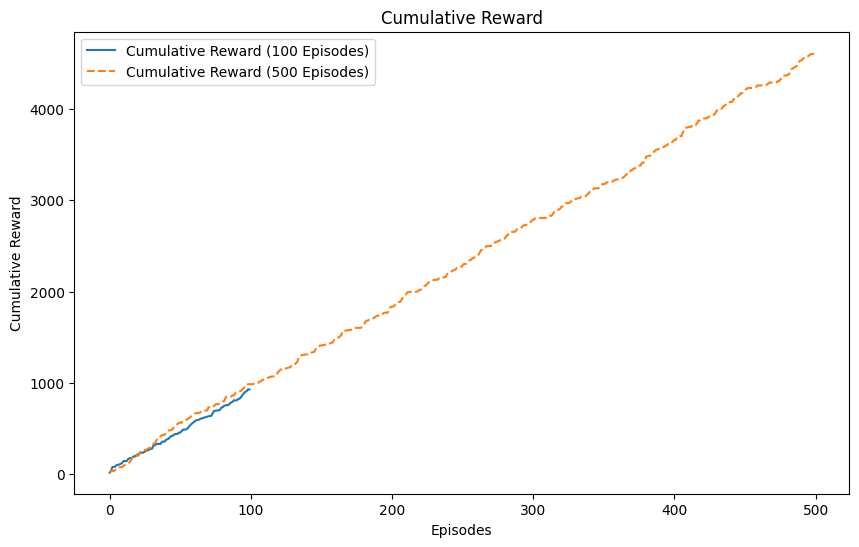

In [77]:
# Cumulative reward for 100 and 500 episodes
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(reward_history_100), label="Cumulative Reward (100 Episodes)")
plt.plot(np.cumsum(reward_history_500), label="Cumulative Reward (500 Episodes)", linestyle='dashed')
plt.xlabel("Episodes")
plt.ylabel("Cumulative Reward")
plt.title("Cumulative Reward")
plt.legend()
plt.show()


Average Reward (100 Episodes): 9.27
Average Reward (500 Episodes): 9.24


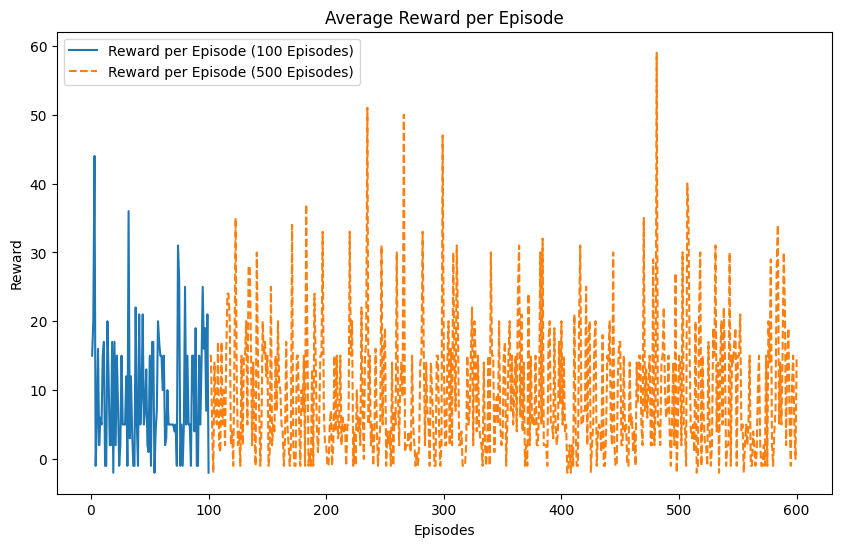

In [78]:
# Average reward per episode
avg_reward_100 = np.mean(reward_history_100)
avg_reward_500 = np.mean(reward_history_500)

print(f"Average Reward (100 Episodes): {avg_reward_100:.2f}")
print(f"Average Reward (500 Episodes): {avg_reward_500:.2f}")

# Plot average reward
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(reward_history_100) + 1), reward_history_100, label="Reward per Episode (100 Episodes)")
plt.plot(range(len(reward_history_100) + 1, len(full_reward_history) + 1), reward_history_500, label="Reward per Episode (500 Episodes)", linestyle='dashed')
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.title("Average Reward per Episode")
plt.legend()
plt.show()


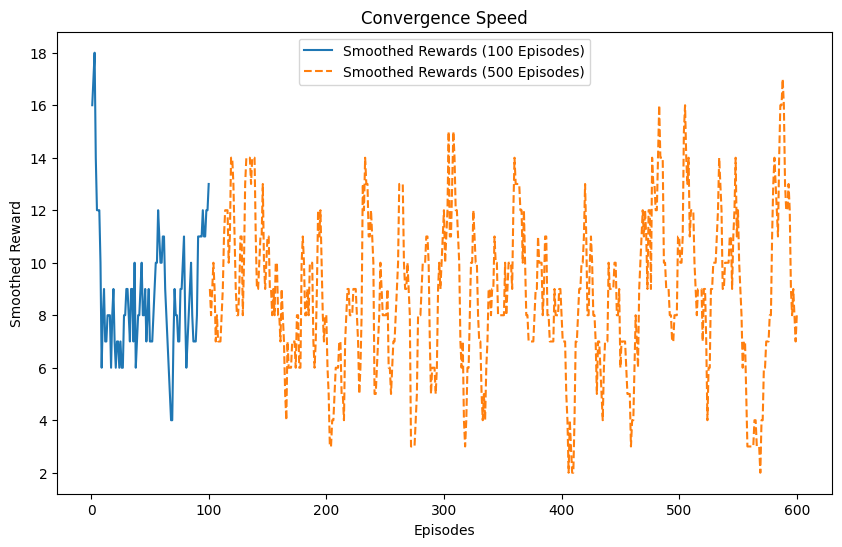

In [79]:
# Convergence speed (smoothed reward over episodes)
from scipy.ndimage import uniform_filter1d

smoothed_rewards_100 = uniform_filter1d(reward_history_100, size=10)
smoothed_rewards_500 = uniform_filter1d(reward_history_500, size=10)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(smoothed_rewards_100) + 1), smoothed_rewards_100, label="Smoothed Rewards (100 Episodes)")
plt.plot(range(len(smoothed_rewards_100) + 1, len(smoothed_rewards_100) + len(smoothed_rewards_500) + 1), smoothed_rewards_500, label="Smoothed Rewards (500 Episodes)", linestyle='dashed')
plt.xlabel("Episodes")
plt.ylabel("Smoothed Reward")
plt.title("Convergence Speed")
plt.legend()
plt.show()


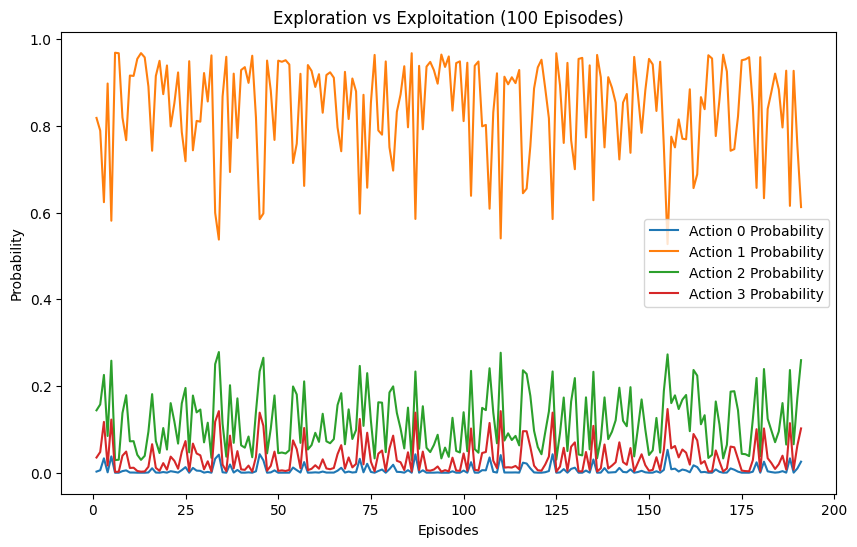

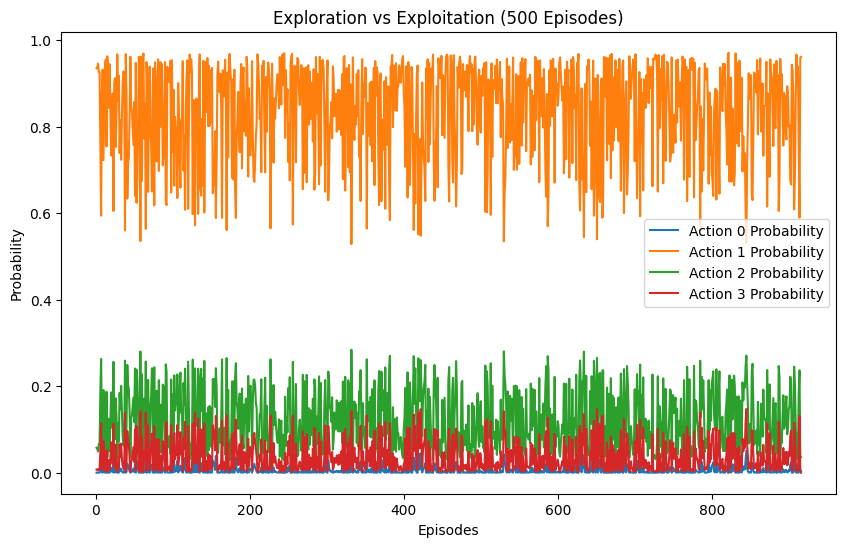

In [80]:
# Exploration vs Exploitation Balance
def plot_exploration_exploitation(exploration_history, episodes, action_size, title):
    exploration_history = np.array(exploration_history)
    plt.figure(figsize=(10, 6))
    for action in range(action_size):
        plt.plot(
            range(1, len(exploration_history) + 1),
            exploration_history[:, action],
            label=f'Action {action} Probability'
        )
    plt.xlabel("Episodes")
    plt.ylabel("Probability")
    plt.title(title)
    plt.legend()
    plt.show()

# Plot Exploration vs Exploitation for 100 Episodes
plot_exploration_exploitation(
    exploration_history_100,
    episodes_100,
    action_size,
    title="Exploration vs Exploitation (100 Episodes)"
)

# Plot Exploration vs Exploitation for 500 Episodes
plot_exploration_exploitation(
    exploration_history_500,
    episodes_500,
    action_size,
    title="Exploration vs Exploitation (500 Episodes)"
)


In [81]:
# Evaluation function with additional metrics
def evaluate_actor_critic(actor, critic, state_representation, episodes=100, max_steps=200):
    total_rewards = []
    total_clicks = 0
    total_add_to_cart = 0
    total_purchases = 0
    total_users = episodes
    total_engagements = 0
    total_revenue = 0

    for episode in range(episodes):
        state = random.choice(state_representation)
        episode_reward = 0

        for step in range(max_steps):
            # Exploitation only (use Actor model to choose actions)
            action_probs = actor.predict(np.array([state]), verbose=0)[0]
            action = np.argmax(action_probs)

            # Simulate reward and next state
            reward_type = random.choice(['click', 'add_to_cart', 'purchase', 'no_action'])
            reward = calculate_reward(reward_type)
            next_state = random.choice(state_representation)

            # Track engagement and revenue metrics
            if reward_type == 'click':
                total_clicks += 1
                total_engagements += 1
            elif reward_type == 'add_to_cart':
                total_add_to_cart += 1
                total_engagements += 1
            elif reward_type == 'purchase':
                total_purchases += 1
                total_engagements += 1
                total_revenue += 20  # Adjusted revenue for purchases

            episode_reward += reward
            state = next_state

            if random.choice([True, False]):  # Simulate terminal state randomly
                break

        total_rewards.append(episode_reward)

    # Calculate metrics
    cumulative_reward = sum(total_rewards)
    avg_reward = cumulative_reward / episodes
    ctr = total_clicks / total_users
    engagement_rate = total_engagements / total_users
    rpu = total_revenue / total_users

    metrics = {
        "Cumulative Reward": cumulative_reward,
        "Average Reward per Episode": avg_reward,
        "Click-Through Rate (CTR)": ctr,
        "Engagement Rate": engagement_rate,
        "Revenue Per User (RPU)": rpu
    }

    return metrics


In [82]:
print("Evaluating Actor-Critic model for 100 episodes...")
metrics_100 = evaluate_actor_critic(actor, critic, state_representation, episodes=100)
for metric, value in metrics_100.items():
    print(f"{metric}: {value:.2f}")

print("\nEvaluating Actor-Critic model for 500 episodes...")
metrics_500 = evaluate_actor_critic(actor, critic, state_representation, episodes=500)
for metric, value in metrics_500.items():
    print(f"{metric}: {value:.2f}")


Evaluating Actor-Critic model for 100 episodes...
Cumulative Reward: 1004.00
Average Reward per Episode: 10.04
Click-Through Rate (CTR): 0.44
Engagement Rate: 1.44
Revenue Per User (RPU): 9.40

Evaluating Actor-Critic model for 500 episodes...
Cumulative Reward: 5295.00
Average Reward per Episode: 10.59
Click-Through Rate (CTR): 0.50
Engagement Rate: 1.50
Revenue Per User (RPU): 10.04


Actor Critic with Collaborative Filtering

C:\Users\srini\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training for 100 Episodes...
Episode 1/100, Total Reward: -0.5
Episode 2/100, Total Reward: 5.0
Episode 3/100, Total Reward: 36.5
Episode 4/100, Total Reward: 25.5
Episode 5/100, Total Reward: 15.5
Episode 6/100, Total Reward: -0.5
Episode 7/100, Total Reward: 26.5
Episode 8/100, Total Reward: 2.5
Episode 9/100, Total Reward: 5.5
Episode 10/100, Total Reward: 22.0
Episode 11/100, Total Reward: 15.0
Episode 12/100, Total Reward: 5.5
Episode 13/100, Total Reward: 10.5
Episode 14/100, Total Reward: 33.5
Episode 15/100, Total Reward: -0.5
Episode 16/100, Total Reward: 5.0
Episode 17/100, Total Reward: 20.5
Episode 18/100, Total Reward: 57.0
Episode 19/100, Total Reward: 18.0
Episode 20/100, Total Reward: 5.5
Episode 21/100, Total Reward: 2.0
Episode 22/100, Total Reward: 8.0
Episode 23/100, Total Reward: -0.5
Episode 24/100, Total Reward: -0.5
Episode 25/100, Total Reward: 2.5
Episode 26/100, Total Reward: -0.5
Episode 27/100, Total Reward: 5.0
Episode 28/100, Total Reward: 26.5
Episode 29

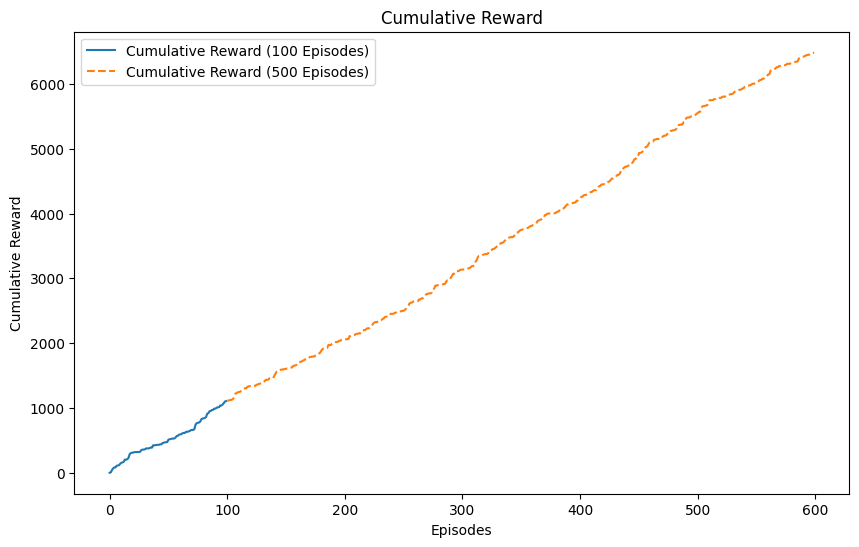

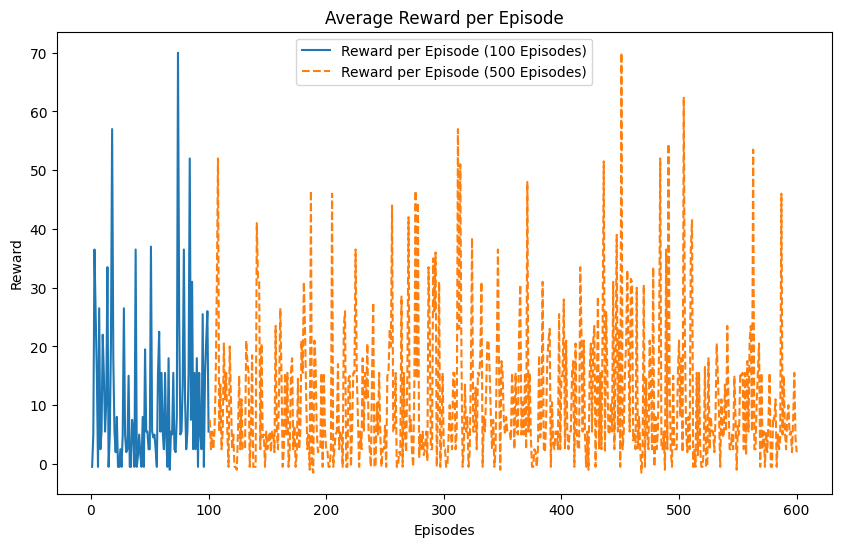

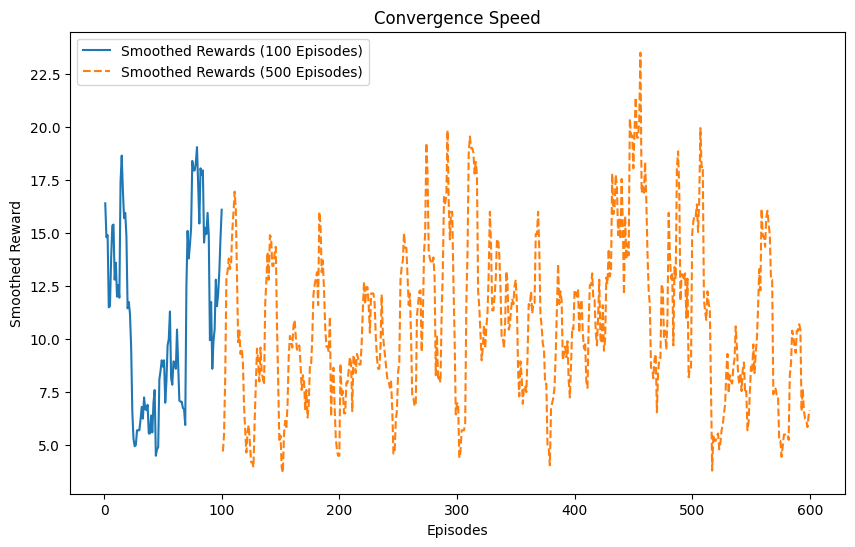


Evaluation Results after 100 Episodes:
Cumulative Reward: 1113.00
Average Reward per Episode: 11.13
Click-Through Rate (CTR): 0.64
Engagement Rate: 1.58
Revenue Per User (RPU): 9.20

Evaluation Results after 500 Episodes:
Cumulative Reward: 5359.50
Average Reward per Episode: 10.72
Click-Through Rate (CTR): 0.46
Engagement Rate: 1.40
Revenue Per User (RPU): 9.32


In [20]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import random
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from collections import deque
import matplotlib.pyplot as plt
import pandas as pd
from scipy.ndimage import uniform_filter1d

# Load and preprocess dataset
data = pd.read_csv("C:/Users/srini/DRL_Project/ecommerce_customer_data_large.csv")

# Preprocessing
relevant_columns = ['Customer Age', 'Product Category', 'Product Price', 'Gender']
data_subset = data[relevant_columns]

# One-hot encode categorical features
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_columns = encoder.fit_transform(data_subset[['Product Category', 'Gender']])
numerical_features = data_subset[['Customer Age', 'Product Price']].values

# Collaborative Filtering Features
user_embeddings = np.random.rand(len(data_subset), 8)  # Example user embeddings
item_embeddings = np.random.rand(len(data_subset), 8)  # Example item embeddings

state_representation = np.hstack((numerical_features, encoded_columns, user_embeddings, item_embeddings))

# Normalize product price for better training
scaler = MinMaxScaler()
scaler.fit(numerical_features)  # Fit scaler on both numerical features
numerical_features = scaler.transform(numerical_features)


actions = encoder.categories_[0]
action_size = len(actions)
state_size = state_representation.shape[1]

# Parameters
gamma = 0.97
learning_rate = 0.0001
batch_size = 64
entropy_beta = 0.01

# Actor Model
def build_actor(state_size, action_size):
    model = tf.keras.Sequential([
        layers.Dense(128, activation='relu', input_shape=(state_size,)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(action_size, activation='softmax')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))
    return model

# Critic Model
def build_critic(state_size):
    model = tf.keras.Sequential([
        layers.Dense(128, activation='relu', input_shape=(state_size,)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(1, activation='linear')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mse')
    return model

# Initialize Actor and Critic
actor = build_actor(state_size, action_size)
critic = build_critic(state_size)

# Training loop
def train_actor_critic_with_logs(actor, critic, episodes, state_representation, memory, reward_history):
    for episode in range(episodes):
        state = random.choice(state_representation)
        total_reward = 0
        previous_actions = []
        memory.clear()

        for step in range(200):
            action_probs = actor.predict(np.array([state]), verbose=0)[0]
            action = np.random.choice(len(action_probs), p=action_probs)

            reward_type = random.choice(['click', 'add_to_cart', 'purchase', 'no_action'])
            reward = calculate_reward(reward_type, previous_actions)
            previous_actions.append(action)

            next_state = random.choice(state_representation)
            done = random.choice([True, False])

            memory.append((state, action, reward, next_state, done))
            total_reward += reward
            state = next_state
            if done:
                break

        train_actor_critic(memory, gamma)
        reward_history.append(total_reward)

        print(f"Episode {episode + 1}/{episodes}, Total Reward: {total_reward}")

# Evaluate function
def evaluate_actor_critic(actor, critic, state_representation, episodes=100):
    total_rewards = []
    total_clicks = 0
    total_add_to_cart = 0
    total_purchases = 0
    total_users = episodes
    total_engagements = 0
    total_revenue = 0

    for episode in range(episodes):
        state = random.choice(state_representation)
        episode_reward = 0
        previous_actions = []  # Track previous actions for diversity bonus

        for step in range(200):
            action_probs = actor.predict(np.array([state]), verbose=0)[0]
            action = np.argmax(action_probs)

            reward_type = random.choice(['click', 'add_to_cart', 'purchase', 'no_action'])
            reward = calculate_reward(reward_type, previous_actions)  # Pass previous actions
            previous_actions.append(action)  # Add action to history

            next_state = random.choice(state_representation)

            if reward_type == 'click':
                total_clicks += 1
                total_engagements += 1
            elif reward_type == 'add_to_cart':
                total_add_to_cart += 1
                total_engagements += 1
            elif reward_type == 'purchase':
                total_purchases += 1
                total_engagements += 1
                total_revenue += 20

            episode_reward += reward
            state = next_state

            if random.choice([True, False]):
                break

        total_rewards.append(episode_reward)

    metrics = {
        "Cumulative Reward": sum(total_rewards),
        "Average Reward per Episode": sum(total_rewards) / episodes,
        "Click-Through Rate (CTR)": total_clicks / total_users,
        "Engagement Rate": total_engagements / total_users,
        "Revenue Per User (RPU)": total_revenue / total_users,
    }

    return metrics

# Train for 100 and 500 Episodes
reward_history_100 = []
reward_history_500 = []
print("Training for 100 Episodes...")
train_actor_critic_with_logs(actor, critic, 100, state_representation, deque(maxlen=5000), reward_history_100)

print("\nTraining for 500 Episodes...")
train_actor_critic_with_logs(actor, critic, 500, state_representation, deque(maxlen=5000), reward_history_500)

# Evaluate Model
metrics_100 = evaluate_actor_critic(actor, critic, state_representation, episodes=100)
metrics_500 = evaluate_actor_critic(actor, critic, state_representation, episodes=500)

# Combine Reward Histories
full_reward_history = reward_history_100 + reward_history_500

# Plot Cumulative Rewards
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(reward_history_100), label="Cumulative Reward (100 Episodes)")
plt.plot(range(len(reward_history_100), len(full_reward_history)),
         np.cumsum(reward_history_500) + np.cumsum(reward_history_100)[-1],
         label="Cumulative Reward (500 Episodes)", linestyle='dashed')
plt.xlabel("Episodes")
plt.ylabel("Cumulative Reward")
plt.title("Cumulative Reward")
plt.legend()
plt.show()

# Average Reward per Episode
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(reward_history_100) + 1), reward_history_100, label="Reward per Episode (100 Episodes)")
plt.plot(range(len(reward_history_100) + 1, len(full_reward_history) + 1), reward_history_500, label="Reward per Episode (500 Episodes)", linestyle='dashed')
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.title("Average Reward per Episode")
plt.legend()
plt.show()

# Convergence Speed (Smoothed Rewards)
smoothed_rewards_100 = uniform_filter1d(reward_history_100, size=10)
smoothed_rewards_500 = uniform_filter1d(reward_history_500, size=10)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(smoothed_rewards_100) + 1), smoothed_rewards_100, label="Smoothed Rewards (100 Episodes)")
plt.plot(range(len(smoothed_rewards_100) + 1, len(smoothed_rewards_100) + len(smoothed_rewards_500) + 1), smoothed_rewards_500, label="Smoothed Rewards (500 Episodes)", linestyle='dashed')
plt.xlabel("Episodes")
plt.ylabel("Smoothed Reward")
plt.title("Convergence Speed")
plt.legend()
plt.show()

# Evaluation Results
print("\nEvaluation Results after 100 Episodes:")
for metric, value in metrics_100.items():
    print(f"{metric}: {value:.2f}")

print("\nEvaluation Results after 500 Episodes:")
for metric, value in metrics_500.items():
    print(f"{metric}: {value:.2f}")


In [21]:
test_scenarios = [
    {"Customer Age": 25, "Product Price": 50, "Product Category": "Books", "Gender": "Male"},
    {"Customer Age": 40, "Product Price": 200, "Product Category": "Electronics", "Gender": "Female"},
    {"Customer Age": 30, "Product Price": 75, "Product Category": "Clothing", "Gender": "Male"},
    {"Customer Age": 50, "Product Price": 300, "Product Category": "Home", "Gender": "Female"},
]




def validate_recommendations(actor, encoder, scaler, scenarios):
    print("\nValidating Recommendations...")
    for i, scenario in enumerate(scenarios):
        try:
            # Prepare input
            customer_age = scenario["Customer Age"]
            product_price = scenario["Product Price"]
            product_category = scenario["Product Category"]
            gender = scenario["Gender"]

            # Encode product category and gender
            encoded_input = encoder.transform([[product_category, gender]])
            numerical_input = scaler.transform([[customer_age, product_price]])

            # Create state representation
            user_embedding = np.random.rand(1, 8)  # Example user embedding
            item_embedding = np.random.rand(1, 8)  # Example item embedding
            state = np.hstack((numerical_input, encoded_input, user_embedding, item_embedding))

            # Predict action probabilities using Actor
            action_probs = actor.predict(state, verbose=0)[0]
            recommended_action_index = np.argmax(action_probs)

            # Print results
            print(f"\nTest Scenario {i + 1}: {scenario}")
            print(f"Recommended Action: {actions[recommended_action_index]} (Probability: {action_probs[recommended_action_index]:.2f})")
            print(f"Action Probabilities: {dict(zip(actions, action_probs))}")

        except Exception as e:
            print(f"Error in Test Scenario {i + 1}: {e}")

# Validate the system
validate_recommendations(actor, encoder, scaler, test_scenarios)



Validating Recommendations...

Test Scenario 1: {'Customer Age': 25, 'Product Price': 50, 'Product Category': 'Books', 'Gender': 'Male'}
Recommended Action: Electronics (Probability: 0.28)
Action Probabilities: {'Books': 0.25726646, 'Clothing': 0.20977171, 'Electronics': 0.2815662, 'Home': 0.25139567}

Test Scenario 2: {'Customer Age': 40, 'Product Price': 200, 'Product Category': 'Electronics', 'Gender': 'Female'}
Recommended Action: Electronics (Probability: 0.28)
Action Probabilities: {'Books': 0.24387136, 'Clothing': 0.24294658, 'Electronics': 0.2833887, 'Home': 0.22979335}

Test Scenario 3: {'Customer Age': 30, 'Product Price': 75, 'Product Category': 'Clothing', 'Gender': 'Male'}
Recommended Action: Books (Probability: 0.28)
Action Probabilities: {'Books': 0.28312486, 'Clothing': 0.21322569, 'Electronics': 0.2513998, 'Home': 0.25224966}

Test Scenario 4: {'Customer Age': 50, 'Product Price': 300, 'Product Category': 'Home', 'Gender': 'Female'}
Recommended Action: Home (Probabili

C:\Users\srini\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
C:\Users\srini\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
C:\Users\srini\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
C:\Users\srini\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
